In [ ]:
from collections import Counter
class Vocabulary:
    def __init__(self, min_freq, tokens=None, reserved_tokens=None) -> None:
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        word_freq = self.count_words(tokens)
        self.token_freq = sorted(word_freq.items(), key=lambda dict_pair:dict_pair[1], reverse=True)
        self.idx_to_token = ['unk'] + reserved_tokens
        self.token_to_idx = {token:idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self.token_freq:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1

    def count_words(self, tokens_list):
        if len(tokens_list) == 0 or isinstance(tokens_list[0], list):
            tokens_list = [token for line in tokens_list for token in line]
        return Counter(tokens_list)
    
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk_idx)
        return [self.__getitem__(token) for token in tokens]


torch.Size([2, 2, 5, 5])


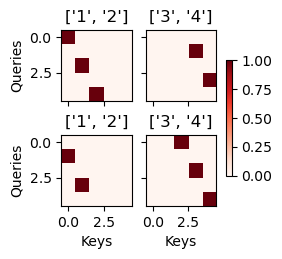

In [7]:
import torch
import matplotlib.pyplot as plt

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5), cmap='Reds'):
    """
    显示矩阵热图的函数\n
    参数:\n
        matrices : 一个四维矩阵列表, shape=(要显示的行数, 要显示的列数, 每个矩阵的行数, 每个矩阵的列数)\n
    """
    print(matrices.shape)
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                            sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)): # 遍历每一行矩阵和它们对应的子图
        for j, (axis, matrix) in enumerate(zip(row_axes, row_matrices)): # 从每一行矩阵遍历每个矩阵和对应的子图
            pcm = axis.imshow(matrix.detach().numpy(), cmap=cmap) # 绘制矩阵热图并返回Pseudocolor Map
            if i == num_rows-1:
                axis.set_xlabel(xlabel)
            if j == 0:
                axis.set_ylabel(ylabel)
            if titles:
                axis.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6) # 利用pcm绘制色条

if __name__ == '__main__':
    attention_weights = torch.eye(10).reshape((2, 2, 5, 5))
    show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries', titles=[['1','2'],['3','4']])
